# **Breaking Bottlenecks: Delivery Gameplan for Olist**
Courtesy of Team Alpha (DTIDSOL-02):
- Josephine Rahma Gunawan
- Rio Pramana
- Risma Widiya Puspadevi

### **Contents:**

1. Understanding the Business Problem
2. Data Cleaning & Familiarisation
3. Exploratory Data Analysis (EDA)
4. Insights & Key Findings
5. Summary of Findings
6. Conclusion & Business Implications
7. Limitations & Considerations
8. Actionable Recommendations

# **Understanding the Business Problems**

### Background and Business Objective

E-commerce has rapidly transformed how people shop, especially in Brazil, where convenience, price, and speed play crucial roles in consumer decisions. According to a report by **NielsenIQ**, Brazilian shoppers cited the following top reasons for choosing online platforms:

- **77%** – Best price  
- **57%** – Delivery time  
- **54%** – Product variety  
- **39%** – Special promotions (e.g., free shipping, discounts, loyalty programmes)

The fact that *delivery time* ranks second highlights just how important a fast, reliable shipping experience is to customers (nearly as important as pricing itself).

For **Olist**, a major e-commerce platform that connects small and medium-sized retailers to marketplaces in Brazil, this puts increasing pressure on fulfilment operations. Delivery performance isn’t just a logistical concern. It's a business-critical metric that can influence customer satisfaction, retention, and ultimately, sales performance.

### Why Focus on On-Time Delivery (OTD)?

To evaluate delivery performance, we focus on the industry-standard metric: **On-Time Delivery (OTD)**. OTD measures the percentage of orders delivered within the promised timeframe and is calculated as:

> **OTD (%) = (Number of on-time deliveries / Total deliveries in the period) × 100**

As highlighted in a blog by **[Delage](https://delage.com.br/blog/otd-on-time-delivery-saiba-tudo-sobre-um-dos-principais-indicadores-para-o-e-commerce/)**, OTD has become one of the most relevant indicators in e-commerce logistics today. It reflects the efficiency of the entire order fulfilment process from the time an order is picked and packed to when it’s handed off by the courier.

Importantly, a survey by **Reclame Aqui** showed that **18.6% of consumers abandon their online shopping carts** if the estimated delivery time doesn’t meet their expectations. While this figure may seem modest at first glance, nearly **1 in 5 lost sales** can severely impact an e-commerce company’s bottom line, especially at scale.

Furthermore, an article by **[Gazeta do Povo](https://www.gazetadopovo.com.br/economia/e-commerce-brasileiro-busca-alternativas-a-correiodependencia-an1xq7tj25k1nnxytsml2tb4q/)** noted that logistics companies proudly advertise achieving **95% OTD** as a sign of operational excellence. While not a formal industry standard, this 95% mark is widely regarded as a benchmark for competitive performance in Brazil’s e-commerce landscape.

### Project Objective

Given the critical role that delivery time plays in consumer satisfaction and conversion rates, the objective of this project is to:

> **Improve Olist's delivery performance by increasing its On-Time Delivery (OTD) rate, aiming for a minimum benchmark of 95%.**

In addition to descriptive and diagnostic analysis, this project also leverages **machine learning to predict whether a delivery will be late or on time** based on various features available at the time of order. The goal is to take **preventive action** on high-risk deliveries such as prioritising processing or flagging for courier follow-up before issues occur.

Through data-driven insights and predictive modelling, this project aims to help Olist optimise its logistics performance, meet customer expectations, and improve overall business outcomes.

# Data Understanding & Cleaning

## Import Libraries & Datasets

In [ ]:
# Data Handling & Manipulation
import pandas as pd                                         # for dataframes, CSV/Excel reading, tabular data manipulation
import numpy as np                                          # for numerical operations and array handling

# Data Visualisation (Static)
import matplotlib.pyplot as plt                             # for creating static plots
from matplotlib.ticker import FuncFormatter                 # for customising tick labels (e.g., currency, %)
import seaborn as sns                                       # for statistical visualisation (heatmaps, distplots, etc.)

# Data Visualisation (Interactive)
import plotly.express as px                                 # for quick and interactive visualisation
import plotly.graph_objects as go                           # for custom interactive plots
from plotly.subplots import make_subplots                   # for interactive subplots

# Statistical Testing & Inference
from statsmodels.stats.proportion import proportions_ztest  # for comparing proportions (e.g., late vs. on-time)
from scipy.stats import (
    normaltest,                                             # for checking normality
    chi2_contingency,                                       # for categorical association
    mannwhitneyu,                                           # for non-parametric testing
    ttest_ind,                                              # for independent sample t-test
    f_oneway,                                               # for one-way ANOVA
    kruskal,                                                # for Kruskal-Wallis test
    kstest                                                  # for Kolmogorov-Smirnov test
)
import statsmodels.api as sm                                # for advanced statistical modelling and diagnostics
import statsmodels.formula.api as smf                       # for formula-based statistical models
from statsmodels.stats.multicomp import pairwise_tukeyhsd   # for post-hoc tests after ANOVA

# Data Quality & Missing Value Visualisation
import missingno as msno                                    # for visualising missing data patterns

# System & Settings
import os                                                   # for file handling and directory operations
import warnings                                             # to suppress or manage warning messages
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)                 # display full content in cells (useful for text data)

In [ ]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load original (raw) datasets:

In [ ]:
original_df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
original_df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
original_df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
original_df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
original_df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
original_df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
original_df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
original_df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
original_df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

## Orders Dataset

In [ ]:
# Load the orders dataset:
original_df_orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23


| Column Name                    | Description                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| `order_id`                    | Unique identifier for each order.                                           |
| `customer_id`                 | Unique identifier for the customer who placed the order.                    |
| `order_status`                | Current status of the order (e.g., delivered, shipped, etc.).     |
| `order_purchase_timestamp`    | Date and time when the order was placed.                                    |
| `order_approved_at`           | Date and time when the order was approved for processing.                   |
| `order_delivered_carrier_date`| Date the order was handed over to the logistics/delivery carrier.           |
| `order_delivered_customer_date`| Date the order was delivered to the customer.                              |
| `order_estimated_delivery_date`| Estimated delivery date promised to the customer at the time of purchase.  |


In [ ]:
original_df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [ ]:
original_df_orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


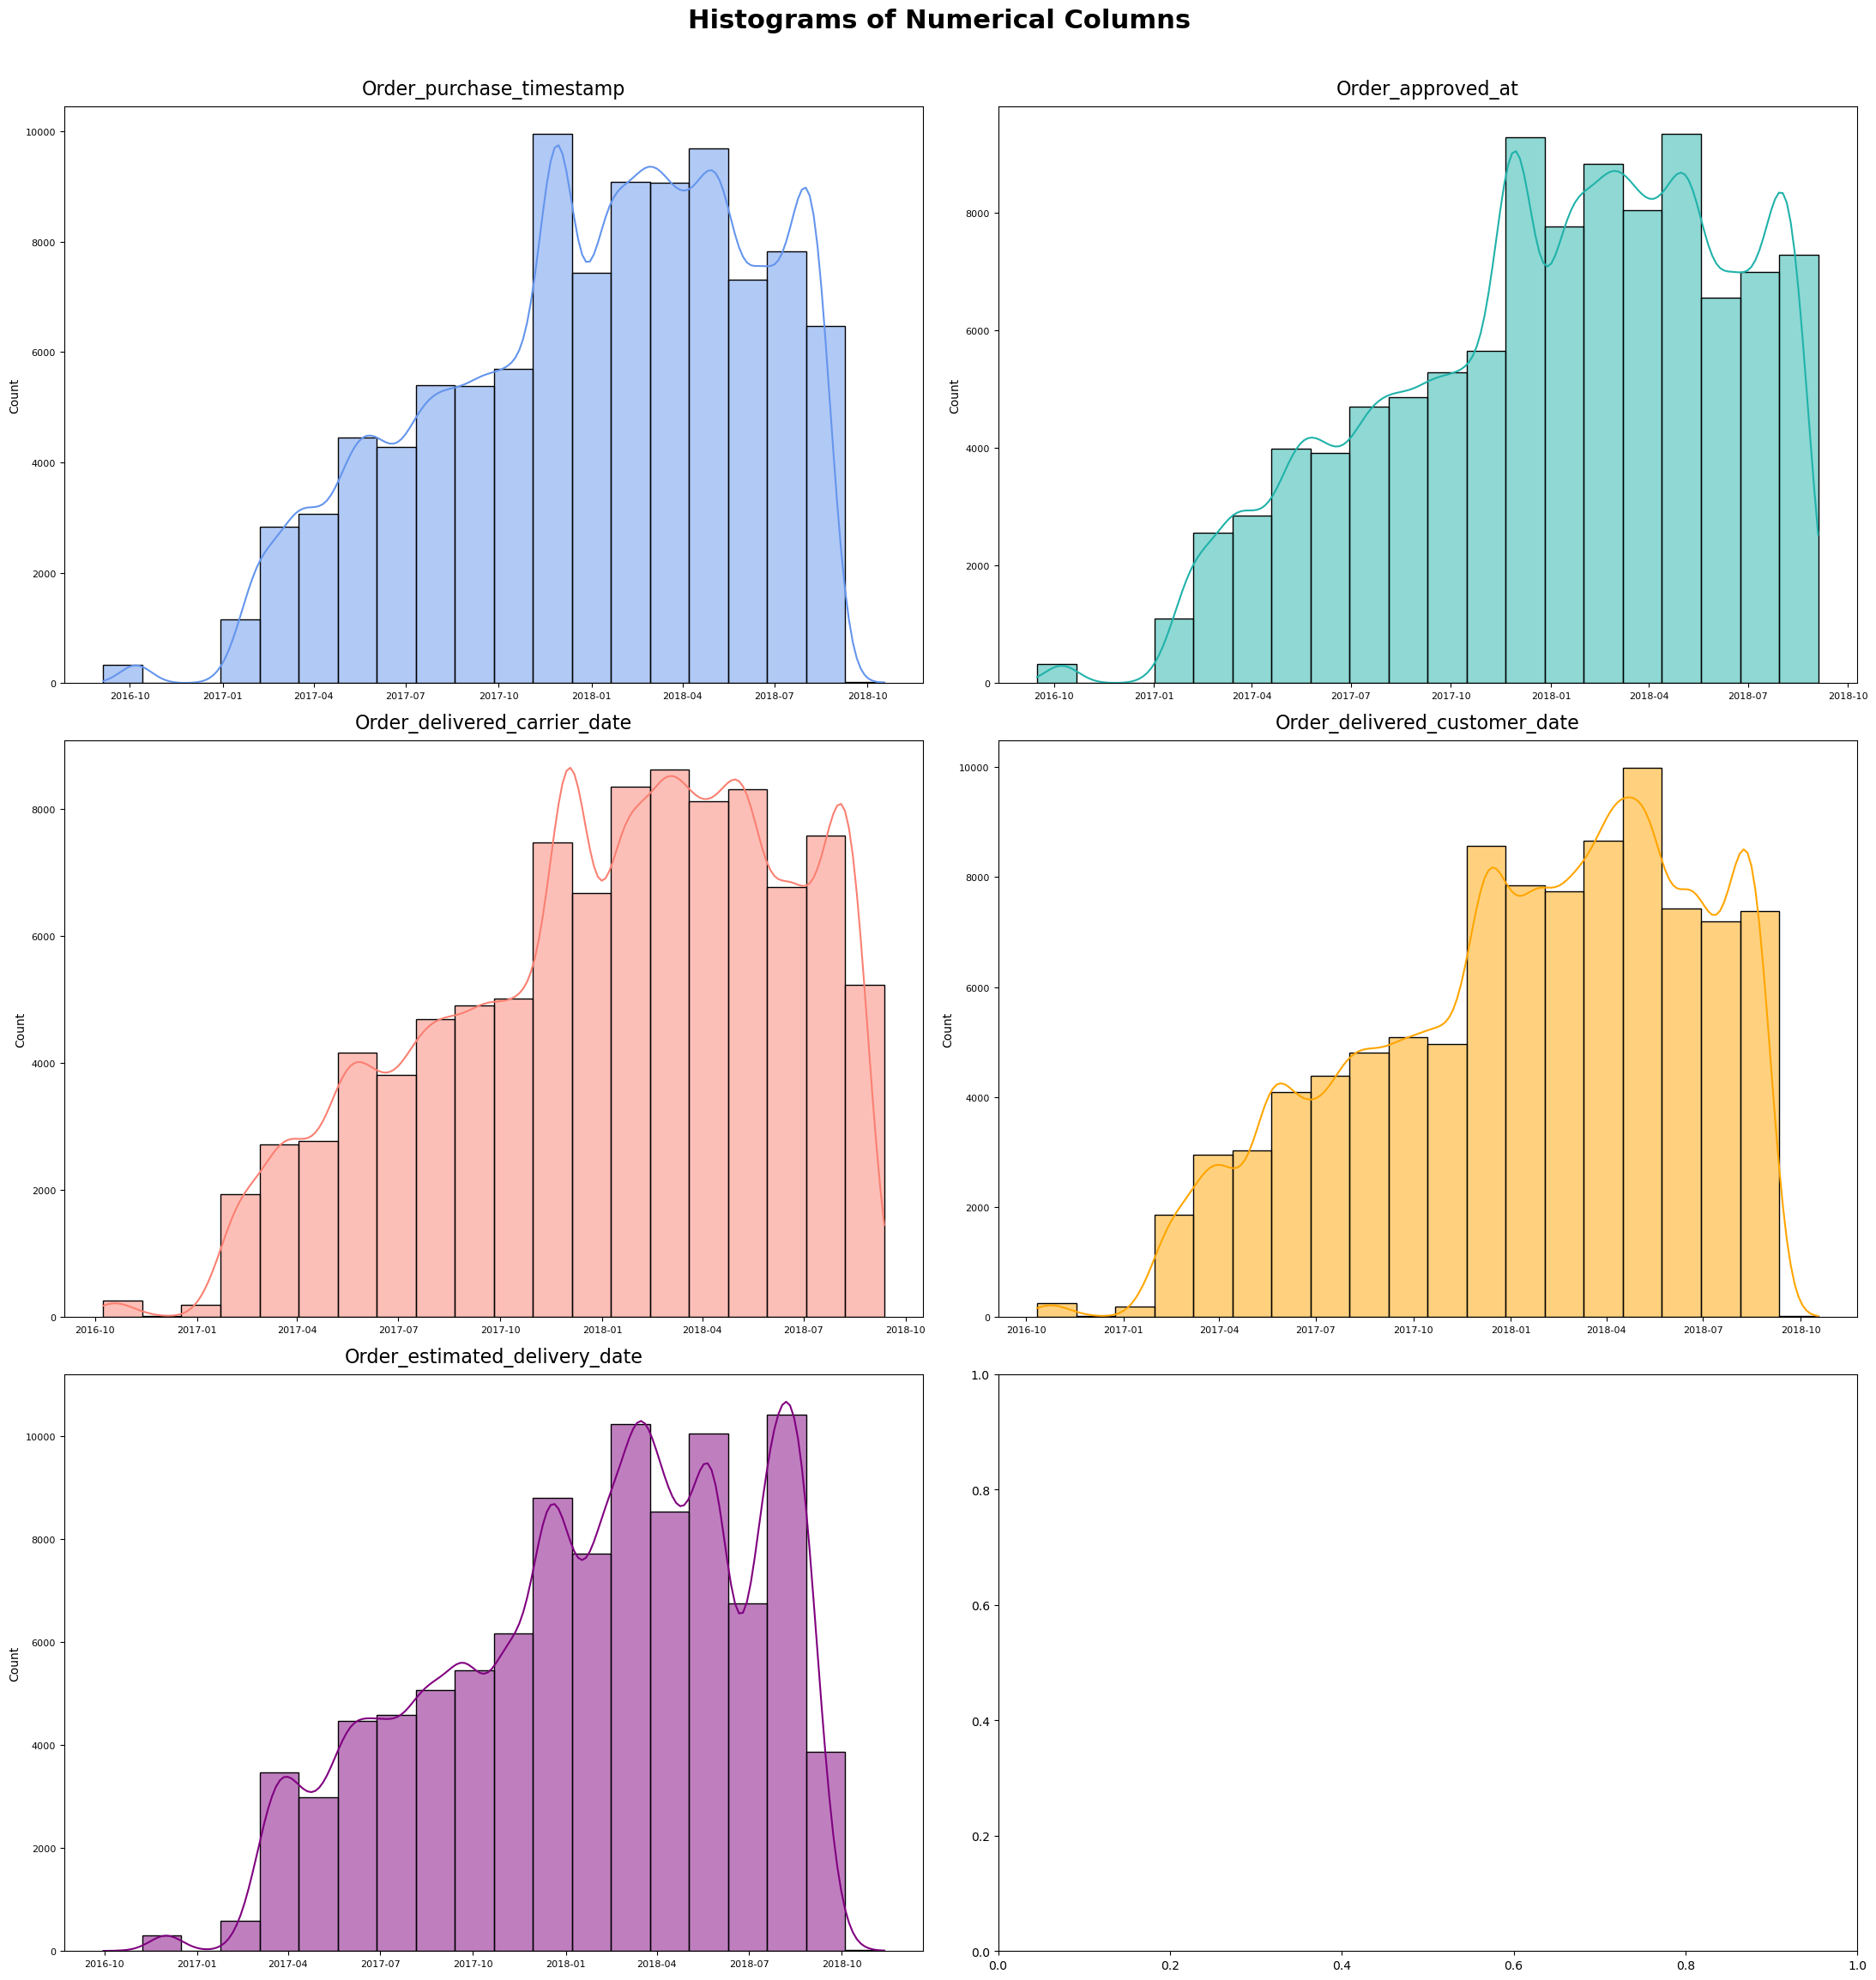

In [ ]:
# data distribution 

# Filter only numerical columns (float and int)
onlynumeric_columns = original_df_orders.select_dtypes(include=['datetime64[ns]']).columns.to_list()

# Calculate the number of rows and columns needed for the plots
n_plots = len(onlynumeric_columns)
n_rows = int(np.ceil(n_plots / 2)) #4colums

# Create the subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(22, 8 * n_rows))
axes = axes.flatten()

# Colors of the histogram
colors = ['cornflowerblue', 'lightseagreen', 'salmon', 'orange', 'purple', 'navy', 'deeppink', 'brown','olivedrab']

# Plot histograms for each numeric column with different colors
for i, column in enumerate(onlynumeric_columns):
    color_index = i % len(colors)  
    sns.histplot(data=original_df_orders, x=column, kde=True, bins=20, ax=axes[i], color=colors[color_index])
    axes[i].set_title(column.capitalize(), fontsize=16, pad=10)  
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Count') 
    axes[i].tick_params(axis='both', labelsize=8)  

plt.suptitle('Histograms of Numerical Columns', fontsize=22, fontweight='bold')

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()


In [ ]:
summary = []

for col in original_df_orders.columns:
    unique_vals = original_df_orders[col].dropna().unique()
    summary.append({
        'Column': col,
        'Unique Count': len(unique_vals),
        'Unique Values': unique_vals
    })

df_summary = pd.DataFrame(summary)
df_summary

,Column,Unique Count,Unique Values
0,order_id,99441,"[e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc7dce0b6741e2150273451, 47770eb9100c2d0c44946d9cf07ec65d, 949d5b44dbf5de918fe9c16f97b45f8a, ad21c59c0840e6cb83a9ceb5573f8159, a4591c265e18cb1dcee52889e2d8acc3, 136cce7faa42fdb2cefd53fdc79a6098, 6514b8ad8028c9f2cc2374ded245783f, 76c6e866289321a7c93b82b54852dc33, e69bfb5eb88e0ed6a785585b27e16dbf, e6ce16cb79ec1d90b1da9085a6118aeb, 34513ce0c4fab462a55830c0989c7edb, 82566a660a982b15fb86e904c8d32918, 5ff96c15d0b717ac6ad1f3d77225a350, 432aaf21d85167c2c86ec9448c4e42cc, dcb36b511fcac050b97cd5c05de84dc3, 403b97836b0c04a622354cf531062e5f, 116f0b09343b49556bbad5f35bee0cdf, 85ce859fd6dc634de8d2f1e290444043, 83018ec114eee8641c97e08f7b4e926f, 203096f03d82e0dffbc41ebc2e2bcfb7, f848643eec1d69395095eb3840d2051e, 2807d0e504d6d4894d41672727bc139f, 95266dbfb7e20354baba07964dac78d5, f3e7c359154d965827355f39d6b1fdac, fbf9ac61453ac646ce8ad9783d7d0af6, acce194856392f074dbf9dada14d8d82, dd78f560c270f1909639c11b925620ea, 91b2a010e1e45e6ba3d133fa997597be, ecab90c9933c58908d3d6add7c6f5ae3, f70a0aff17df5a6cdd9a7196128bd354, 1790eea0b567cf50911c057cf20f90f9, 989225ba6d0ebd5873335f7e01de2ae7, d887b52c6516beb39e8cd44a5f8b60f7, b276e4f8c0fb86bd82fce576f21713e0, 8563039e855156e48fccee4d611a3196, 60550084e6b4c0cb89a87df1f3e5ebd9, 5acce57f8d9dfd55fa48e212a641a69d, 434d158e96bdd6972ad6e6d73ddcfd22, 7206b86ea789983f7a273ea7fa0bc2a8, 1e7aff52cdbb2451ace09d0f848c3699, 6ea2f835b4556291ffdc53fa0b3b95e8, 948097deef559c742e7ce321e5e58919, d22e9fa5731b9e30e8b27afcdc2f8563, ee64d42b8cf066f35eac1cf57de1aa85, 6ebaec694d7025e2ad4a05dba887c032, d17dc4a904426827ca80f2ccb3a6be56, 25f4376934e13d3508486352e11a5db0, 5820a1100976432c7968a52da59e9364, 2ce1ad82022c1ba30c2079502ac725aa, 138849fd84dff2fb4ca70a0a34c4aa1c, 47aa4816b27ba60ec948cd019cc1afc1, 9faeb9b2746b9d7526aef5acb08e2aa0, 641fb0752bf5b5940c376b3a8bb9dc52, e425680f760cbc130be3e53a9773c584, 40c5e18f7d112b59b3e5113a59a905b3, 734e7d1bbaeb2ff82521ca0fe6fb6f79, 66e4624ae69e7dc89bd50222b59f581f, a685d016c8a26f71a0bb67821070e398, 2edfd6d1f0b4cd0db4bf37b1b224d855, 68873cf91053cd11e6b49a766db5af1a, f346ad4ee8f630e5e4ddaf862a34e6dd, 8f06cc6465925031568537b815f1198d, ccbabeb0b02433bd0fcbac46e70339f2, 688052146432ef8253587b930b01a06d, f271576bed568e896f99eb710cd3a6f8, 686541986ecfb7d9296eb67719973bf0, 68e48e68da1f50f7c5838ea75e3a20dd, b52cc4919de82b4d696a4380d10804a3, fdf128b3630c21adc9ca4fb8a51b68ec, a6aeb116d2cb5013eb8a94585b71ffef, fa516182d28f96f5f5c651026b0749ee, 6abaad69b8b349c3a529b4b91ce18e46, 974c1993ab8024d3ed16229183c2308d, 82bce245b1c9148f8d19a55b9ff70644, a910f58086d58b3ae6f37aa712d377b9, bd4bd0194d6d29f83b8557d4b89b572a, 634e8f4c0f6744a626f77f39770ac6aa, 6d25592267349b322799e2beb687871e, b8801cccd8068de30112e4f49903d74a, 2711a938db643b3f0b62ee2c8a2784aa, 3bc77ce8be27211bac313c2daa402d1a, 10c320f977c6a18f91b2d14be13128c6, 0a4a2fccb27bd83a892fa503987a595b, e4de6d53ecff736bc68804b0b6e9f635, 6b860b35691d486e45dc98e3514ec5f6, ec341c54a5ebf8ee0a67a8632aa7579b, cadbb3657dac2dbbd5b84b12e7b78aad, 9defaf92cff22420e4e8ef7784815a55, 20e0101b20700188cadb288126949685, 0e782c3705510e717d28907746cbda82, d3d6788577c9592da441752e8a1dd5e3, 86f21bf63784876b9fd6d35f46581d72, 8447ff843b2616c50c0ced28ab1dae03, f169bd689fb8b32ccd62df9050aebc0b, 77e9941864fc840be8e4b1ba5347c0f7, 41bb5cee06dbf170878a9ef93ac7e7f5, 6a0a8bfbbe700284feb0845d95e0867f, f7959f8385f34c4f645327465a1c9fc4, 23f553848a03aaab35bb3f9f87725125, ...]"
1,customer_id,99441,"[9ef432eb6251297304e76186b10a928d, b0830fb4747a6c6d20dea0b8c802d7ef, 41ce2a54c0b03bf3443c3d931a367089, f88197465ea7920adcdbec7375364d82, 8ab97904e6daea8866dbdbc4fb7aad2c, 503740e9ca751ccdda7ba28e9ab8f608, ed0271e0b7da060a393796590e7b737a, 9bdf08b4b3b52b5526ff42d37d47f222, f54a9f0e6b351c431402b8461ea51999, 31ad1d1b63eb9962463f764d4e6e0c9d, 494dded5b201313c64ed7f100595b95c, 7711cf624183d843aafe81855097bc37, d3e3b74c766bc6214e0c830b17ee2341, 19402a48fe860416adf93348aba37740, 3df704f53d3f1d4818840b34ec672a9f, 3b6828a5

In [ ]:
# Unique order_status values:
print(original_df_orders['order_status'].unique())

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


In [ ]:
# Get a sample row for each order_status value
status_examples = original_df_orders.groupby('order_status').first().reset_index()

# Create a display-friendly dataframe
display_df = pd.DataFrame()

for _, row in status_examples.iterrows():
    # Format the row data
    formatted_row = row.copy()
    
    # Format datetime columns to be more readable
    for col in row.index:
        if pd.api.types.is_datetime64_any_dtype(row[col]):
            formatted_row[col] = "N/A" if pd.isna(row[col]) else row[col].strftime('%Y-%m-%d %H:%M:%S')
    
    # Add the status name as a separate row for better visualization
    display_df = pd.concat([display_df, pd.DataFrame([formatted_row])])

# Display the dataframe with better formatting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wider display
pd.set_option('display.colheader_justify', 'center')  # Center column headers

# create a more compact display focusing on key columns
compact_view = display_df[['order_status', 'order_purchase_timestamp', 'order_approved_at', 
                         'order_delivered_carrier_date', 'order_delivered_customer_date', 
                         'order_estimated_delivery_date']]

print("\n=== COMPACT ORDER STATUS EXAMPLES ===\n")
display(compact_view)


=== COMPACT ORDER STATUS EXAMPLES ===



,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
1,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,2018-01-29 22:33:25,2018-03-21 22:03:51,2018-08-14
2,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
3,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
4,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
5,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
6,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
7,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05


In [ ]:
# Count the number of orders that are not "delivered"
non_delivered_count = original_df_orders[original_df_orders['order_status'] != 'delivered'].shape[0]

# Get the percentage of non-delivered orders
total_orders = original_df_orders.shape[0]
non_delivered_percentage = (non_delivered_count / total_orders) * 100

# Count by each status type that isn't "delivered"
status_counts = original_df_orders[original_df_orders['order_status'] != 'delivered']['order_status'].value_counts()

print(f"Total orders: {total_orders}")
print(f"Non-delivered orders: {non_delivered_count} ({non_delivered_percentage:.2f}%)")
print("\nBreakdown by status:")
display(status_counts)

Total orders: 99441
Non-delivered orders: 2963 (2.98%)

Breakdown by status:


order_status
shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: count, dtype: int64

For our project scope, we are only interested in "Delivered" orders since we are looking to evaluate the delivery performance

In [ ]:
# Keep only delivered orders:
df_orders_delivered = original_df_orders[original_df_orders['order_status'] == 'delivered'].copy()
df_orders_delivered.shape

(96478, 8)

In [ ]:
df_orders_delivered.duplicated().sum()

0

In [ ]:
df_orders_delivered.drop(columns='order_id').duplicated().sum()

0

In [ ]:
df_orders_delivered.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

# **Data Merging**

Load cleaned datasets

In [ ]:
cleaned_delivered_df_orders           = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
cleaned_df_customers        = read_olist_csv('../data/cleaned_data/olist_customers_dataset.csv')
cleaned_delivered_df_order_items      = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
cleaned_delivered_df_order_payments   = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')
cleaned_delivered_df_reviews          = read_olist_csv('../data/cleaned_data/olist_order_reviews_dataset.csv')
cleaned_df_products         = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
cleaned_df_prod_cat_tr      = read_olist_csv('../data/cleaned_data/product_category_name_translation.csv')
cleaned_df_sellers          = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

## Dataset Merging Strategy

![image.png](attachment:image.png)

To prepare the dataset for analysis and modelling, we follow this structured merging sequence:

1. **Start with `orders`** as the central table containing order lifecycle and timestamp information.
2. **Merge `orders` with `customers`** on `customer_id` to include customer demographic details such as city and state.
3. **Merge `order_items` with `products`** on `product_id` to bring in product-level information like category and attributes.
4. **Merge the `order_items + products` result with `sellers`** on `seller_id` to add seller location data.
5. **Merge the `orders + customers` dataset with the `order_items + products + sellers` dataset** on `order_id`, consolidating order-level and item-level information.
6. **Merge the result with `order_payments`** on `order_id` to include payment method and instalment data.
7. **Merge the result with `order_reviews`** on `order_id` to add customer feedback and review scores.
8. **Finally, merge the complete dataset with `product_category_name_translation`** on `product_category_name` to translate Portuguese product categories into English.

This step-by-step merging approach ensures that all relevant aspects such as orders, customers, products, sellers, payments, and reviews are integrated into a single, comprehensive dataset for robust analysis.

### Orders ⇄ Customers

In [ ]:
# Merge orders and customers tables (1:1 relationship) using 'customer_id' as key:
merged_orders_customers = cleaned_delivered_df_orders.merge(
    cleaned_df_customers,       # for customers table
    on='customer_id',           # the key for merging
    how='left',                 # to keep all orders and add matching customer info
    indicator=True              # to add a column showing the source of each row match
)

# Print count of merge status (should be all 'both' if merge is successful):
print("orders ⇄ customers:", merged_orders_customers['_merge'].value_counts())

# Ensure all merged rows matched (i.e., each order has a customer):
assert (merged_orders_customers['_merge'] == 'both').all(), "⚠️ Some orders missing customers!"

# Drop the merge indicator column now that the check is done:
merged_orders_customers.drop(columns=['_merge'], inplace=True)

# Result:
display(merged_orders_customers.head())

orders⇄customers: _merge
both          96282
left_only         0
right_only        0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [ ]:
# Check for any missing values in the merged DataFrame:
merged_orders_customers.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

### Order Items ⇄ Products

In [ ]:
# Enrich the order_items table with product details (1:1 relationship) using 'product_id':
enriched_order_items = cleaned_delivered_df_order_items.merge(
    cleaned_df_products,       # for product information table
    on='product_id',           # the key to merge on
    how='left',                # to keep all order items and attach matching product data
    indicator=True             # to include a column showing the source of each match
)

# Display merge status counts (useful for checking if any items lacked product info):
print("order_items ⇄ products:", enriched_order_items['_merge'].value_counts())

# Optional validation:
# assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing products!"
# enriched_order_items.drop(columns=['_merge'], inplace=True)

# Result:
display(enriched_order_items.head())

order_items⇄products: _merge
both          109936
left_only         17
right_only         0
Name: count, dtype: int64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,both
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,both
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,both
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,both
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,both


In [ ]:
# Check for any missing values in the enriched DataFrame:
enriched_order_items.isna().sum()

order_id                       0
order_item_id                  0
product_id                     0
seller_id                      0
shipping_limit_date            0
price                          0
freight_value                  0
product_category_name         17
product_name_lenght           17
product_description_lenght    17
product_photos_qty            17
product_weight_g              17
product_length_cm             17
product_height_cm             17
product_width_cm              17
_merge                         0
dtype: int64

In [ ]:
# Check for items without products:
enriched_order_items[enriched_order_items['_merge'] == 'left_only']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge
6949,101157d4fae1c9fb74a00a5dee265c25,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-11 08:02:26,29.0,14.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9011,1521c6bb7b1028154c8c67cf80fa809f,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:10:16,29.0,16.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28006,415cfaaaa8cea49f934470548797fed1,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:35:19,29.0,14.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28007,415cfaaaa8cea49f934470548797fed1,2,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:35:19,29.0,14.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
38344,595316a07cd3dea9db7adfcc7e247ae7,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-08-18 04:26:04,39.0,9.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47252,6e150190fbe04c642a9cf0b80d83ee16,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-06-30 16:45:14,39.0,16.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47790,6f497c40431d5fb0cfbd6c943dd29215,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-11 05:55:32,29.0,10.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
69432,a2456e7f02197951664897a94c87242d,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-06 11:50:09,29.0,24.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
71800,a7a43f469c0d7bdb0a23a82db125aefa,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-08-28 13:15:11,39.0,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
80822,bbfc7badbed2f1828e22b6d629201bd4,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-07-18 04:04:10,39.0,11.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [ ]:
# Remove order items that don't have matching products
print(f"Removing {(enriched_order_items['_merge'] == 'left_only').sum()} order items without matching products")
enriched_order_items = enriched_order_items[enriched_order_items['_merge'] == 'both']

Removing 17 order items without matching products


In [ ]:
# Drop the merge indicator column now that the check is done:
enriched_order_items.drop(columns=['_merge'], inplace=True)
enriched_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0


### Order Items + Products ⇄ Sellers

In [ ]:
# Enrich the order_items data with seller details (1:1 relationship) using 'seller_id':
enriched_order_items = enriched_order_items.merge(
    cleaned_df_sellers,       # for seller information table
    on='seller_id',           # the key to merge on
    how='left',               # to keep all order items, attach matching seller data
    indicator=True            # to include a column showing the source of each match
)

# Display merge status counts (helps verify if all items had a matching seller):
print("enriched_order_items ⇄ sellers:", enriched_order_items['_merge'].value_counts())

# Ensure all items have seller information (raise error if any do not):
assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing sellers!"

# Drop the merge indicator column as it's no longer needed:
enriched_order_items.drop(columns=['_merge'], inplace=True)

# Result:
enriched_order_items.head()

enriched_order_items⇄sellers: _merge
both          109936
left_only          0
right_only         0
Name: count, dtype: int64


In [ ]:
enriched_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR


### Orders + Customers ⇄ Order Items + Products + Sellers

In [ ]:
# Merge combined orders + customers data with enriched order_items (1:many relationship):
merged_orders_items = merged_orders_customers.merge(
    enriched_order_items,     # for the table that's already enriched with product and seller info
    on='order_id',            # to merge based on shared order ID
    how='left',               # to keep all orders, even if they have no associated items
    indicator=True            # to add a column indicating merge result (both/left_only/right_only)
)

# Print how many records matched successfully vs. not:
print("(orders + cust) ⇄ items:", merged_orders_items['_merge'].value_counts())

# Check that all items from order_items matched with an order:
n_items = len(enriched_order_items)
matched_items = (merged_orders_items['_merge'] == 'both').sum()
assert matched_items == n_items, f"⚠️ Only {matched_items}/{n_items} items matched!"

# Optional validation:
# assert (merged_orders_items['_merge'] == 'left_only').sum() == 0, "⚠️ Some orders have no items!"
# merged_orders_items.drop(columns=['_merge'], inplace=True)

# Result:
merged_orders_items.head()

(orders+cust)⇄items: _merge
both          109936
left_only         15
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,both
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,both
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,both
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG,both
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,8752.0,mogi das cruzes,SP,both


**Note: 15 orders** have no associated items because their corresponding order items were dropped earlier due to missing product information. To maintain consistency and ensure data integrity, we will also drop these 15 orders from the merged dataset.

In [ ]:
# Identify orders that do not have any matching items (likely due to earlier drops):
orders_without_items = merged_orders_items[merged_orders_items['_merge'] == 'left_only']
print(f"Number of orders without items: {len(orders_without_items)}")

# Remove those unmatched orders from the merged dataset:
print(f"Removing {(merged_orders_items['_merge'] == 'left_only').sum()} orders without matching items")
merged_orders_items = merged_orders_items[merged_orders_items['_merge'] == 'both']

# Drop the merge indicator column as it's no longer needed:
merged_orders_items.drop(columns=['_merge'], inplace=True)

# Check the shape of the final dataset after removing unmatched orders:
print(f"Final shape of merged_orders_items: {merged_orders_items.shape}")
merged_orders_items.head()

Number of orders without items: 15
Removing 15 orders without matching items
Final shape of merged_orders_items: (109936, 29)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,8752.0,mogi das cruzes,SP


In [ ]:
# Check for any missing values in the final merged DataFrame:
merged_orders_items.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

### Orders + Items + Customers + Sellers + Products ⇄ Payments

In [ ]:
# Merge merged_orders_items with payment data (1 order can have multiple payment entries):
merged_orders_payments = merged_orders_items.merge(
    cleaned_delivered_df_order_payments,
    on='order_id',
    how='left',
    indicator=True
)

# Check merge status to ensure all payments match an existing order:
print("with payments:", merged_orders_payments['_merge'].value_counts())

# Raise an alert if there are payment records not linked to any order:
assert not (merged_orders_payments['_merge'] == 'right_only').any(), "⚠️ Orphan payments exist!"

# Optionally drop the merge indicator column once confirmed:
# merged_orders_payments.drop(columns=['_merge'], inplace=True)

# Result:
merged_orders_payments.head()

with payments: _merge
both          114761
left_only          3
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,1.0,credit_card,1.0,18.12,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,3.0,voucher,1.0,2.00,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,2.0,voucher,1.0,18.59,both
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,1.0,boleto,1.0,141.46,both
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,1.0,credit_card,3.0,179.12,both


In [ ]:
# Check for orders without payments:
merged_orders_payments[merged_orders_payments['_merge'] == 'left_only'][['order_id', 'order_item_id', 'product_id',
                                                                         'payment_sequential', 'payment_type', 'payment_installments', 'payment_value',
                                                                         'price', 'freight_value']]

,order_id,order_item_id,product_id,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value
35511,bfbd0f9bdef84302105ad712db648a6c,1.0,5a6b04657a4c5ee34285d1e4619a96b4,NaN,NaN,NaN,NaN,44.99,2.83
35512,bfbd0f9bdef84302105ad712db648a6c,2.0,5a6b04657a4c5ee34285d1e4619a96b4,NaN,NaN,NaN,NaN,44.99,2.83
35513,bfbd0f9bdef84302105ad712db648a6c,3.0,5a6b04657a4c5ee34285d1e4619a96b4,NaN,NaN,NaN,NaN,44.99,2.83


In [ ]:
original_df_order_payments[original_df_order_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']

,order_id,payment_sequential,payment_type,payment_installments,payment_value


Reason for keeping the rows:

There is **1 order** (with **3 associated items**) that is missing payment information even in the original payments dataset. While the `payment_value` can be **inferred** by summing the `price` and `freight_value`, the remaining payment fields would need to be **imputed using synthetic values**. To ensure data completeness, we will:
- **Retain** the order
- **Infer** the `payment_value`
- **Impute** other missing fields with synthetic values
- **Flag** this order to indicate it contains imputed payment information

In [ ]:
# original_df_order_payments['payment_type'].value_counts()

In [ ]:
# missing_payment_mask = merged_orders_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c'

# # Calculate the payment value from price + freight_value
# merged_orders_payments.loc[missing_payment_mask, 'payment_value'] = (
#     merged_orders_payments.loc[missing_payment_mask, 'price'] + 
#     merged_orders_payments.loc[missing_payment_mask, 'freight_value']
# )

# # Set payment type to 'not_defined' (synthetic value, but this category exists in the original dataset)
# merged_orders_payments.loc[missing_payment_mask, 'payment_type'] = 'not_defined'

# # Add a flag to indicate this order has synthetic payment data
# merged_orders_payments['missing_payment_details'] = False
# merged_orders_payments.loc[missing_payment_mask, 'missing_payment_details'] = True

# merged_orders_payments[missing_payment_mask]

Alternative Approach: **Deleting the Row**

An alternative would be to **remove the order entirely** due to the missing payment information. This ensures that all records in the dataset have complete payment data and eliminates the need for imputation.

In [ ]:
# Delete the 3 rows with missing payment info instead of keeping them
print(f"Removing {(merged_orders_payments['_merge'] == 'left_only').sum()} orders without payment information")
merged_orders_payments = merged_orders_payments[merged_orders_payments['_merge'] == 'both']

Removing 3 orders without payment information


In [ ]:
# Drop the merge indicator column now that the check is done:
merged_orders_payments.drop(columns=['_merge'], inplace=True)
merged_orders_payments.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,1.0,credit_card,3.0,179.12


In [ ]:
# Check for any remaining missing values in the final merged DataFrame:
merged_orders_payments.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

### Orders + Items + Customers + Sellers + Products + Payments ⇄ Reviews

In [ ]:
# Merge enriched_orders with reviews (1:1 relationship):
merged_orders_reviews = merged_orders_payments.merge(
    cleaned_delivered_df_reviews,   # for reviews table
    on='order_id',                  # to merge based on shared order ID
    how='left',                     # to keep all orders and attach matching reviews
    indicator=True                  # to add a column showing the source of each row match
)

# Check merge result to identify unmatched records:
print("Review merge status:", merged_orders_reviews['_merge'].value_counts())

# Ensure no orphaned reviews exist (i.e., reviews without matching orders):
assert not (merged_orders_reviews['_merge'] == 'right_only').any(), "⚠️ Orphan reviews found!"

# Result:
# merged_orders_reviews.drop(columns=['_merge'], inplace=True)
merged_orders_reviews.head()

with reviews: _merge
both          113721
left_only       1372
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,both
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,both
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,both


In [ ]:
# Check for orders without reviews:
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge
19,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-01-12 19:09:04,1299.00,77.45,construcao_ferramentas_construcao,38.0,143.0,2.0,20850.0,100.0,25.0,50.0,8840.0,mogi das cruzes,SP,1.0,credit_card,10.0,1376.45,NaN,NaN,NaN,NaN,NaT,NaT,left_only
65,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,51838d41add414a0b1b989b7d251d9ee,13068,campinas,SP,1.0,ebd7c847c1e1cb69ec374ae0ebee1f4c,391fc6631aebcf3004804e51b40bcf1e,2017-03-17 18:14:36,84.90,14.36,moveis_decoracao,50.0,228.0,3.0,1200.0,40.0,15.0,30.0,14940.0,ibitinga,SP,1.0,boleto,1.0,99.26,NaN,NaN,NaN,NaN,NaT,NaT,left_only
98,b8801cccd8068de30112e4f49903d74a,f26a435864aebedff7f7c84f82ee229f,delivered,2017-07-30 03:06:35,2017-07-30 03:25:08,2017-07-31 16:42:54,2017-08-01 14:27:31,2017-08-16,bb4d84a2b45b22ed710ac8c0dec63d1a,8552,poa,SP,1.0,154e7e31ebfa092203795c972e5804a6,cc419e0650a3c5ba77189a1882b7556a,2017-08-08 03:25:08,19.99,7.78,beleza_saude,48.0,575.0,1.0,100.0,20.0,15.0,15.0,9015.0,santo andre,SP,1.0,credit_card,2.0,27.77,NaN,NaN,NaN,NaN,NaT,NaT,left_only
209,ce9feeba53c652dd6569cca62e2bb287,f7398fc942c8fa80e5419ae52e49f7fb,delivered,2018-04-15 19:42:06,2018-04-15 19:55:20,2018-04-19 14:32:30,2018-04-20 23:12:11,2018-04-26,d01cf8c6c7c836c5dd9320585928f42b,6414,barueri,SP,1.0,28b5fef7b6d63771e9784bc68c783793,d91fb3b7d041e83b64a00a3edfb37e4f,2018-04-19 19:55:20,45.00,11.86,eletrodomesticos,60.0,564.0,1.0,1500.0,65.0,8.0,38.0,11704.0,praia grande,SP,1.0,credit_card,1.0,56.86,NaN,NaN,NaN,NaN,NaT,NaT,left_only
287,7e3e92dc3eaf5389f32da97228f7dd0e,62d50e9a714ac024c196d9548594e2aa,delivered,2017-07-02 20:47:24,2017-07-02 21:03:55,2017-07-03 11:42:08,2017-07-11 20:22:31,2017-07-25,ba77e9b6506636dcbd03e463d4786f24,95059,caxias do sul,RS,1.0,f0bc0aed23d451f89495f7650d81e244,a3a38f4affed601eb87a97788c949667,2017-07-06 21:03:55,79.90,15.31,beleza_saude,45.0,124.0,2.0,900.0,30.0,5.0,23.0,89204.0,joinville,SC,1.0,credit_card,4.0,95.21,NaN,NaN,NaN,NaN,NaT,NaT,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,2fcdb0c004a2a538d3dd724ea76916bd,cf826be53b1fe4a39bc33c7f5f827835,delivered,2017-11-22 11:39:00,2017-11-22 11:49:05,2017-11-23 22:58:51,2017-12-15 00:23:25,2017-12-18,d92462d83762d5e5c112bccc344119e6,65940,grajau,MA,1.0,8d139b1550c8cc91a3babc9cfe9fc147,c9c7905cffc4ef9ff9f113554423e671,2017-11-28 11:48:35,55.00,35.71,telefonia,53.0,1017.0,5.0,500.0,16.0,6.0,11.0,6871.0,itapecerica da serra,SP,1.0,credit_card,9.0,90.71,NaN,NaN,NaN,NaN,NaT,NaT,left_only
114735,2f2df159f26ddb73d55ee72372200d3e,86a7245fffe6a418ca1658a13ecc4531,delivered,2017-07-17 01:19:50,2017-07-17 01:30:09,2017-07-17 22:14:50,2017-07-26 09:44:00,2017-08-09,1d532194f005426adcdf6d969640d56e,35240,conselheiro pena,MG,1.0,4052517cac9e78357d895976124f6972,ce27a3cc3c8cc1ea79d11e561e9bebb6,2017-07-24 01:30:09,150.00,16.81,eletronicos,31.0,736.0

**Note:** There are **1,372 order items** that do not have associated reviews. This is acceptable, as submitting a review is optional. To capture this, we'll introduce a new flag column called `has_review`, which will indicate whether or not a review exists for each order item.

In [ ]:
# Add an explicit flag
merged_orders_reviews['has_review'] = merged_orders_reviews['review_id'].notna()
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge,has_review
19,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-01-12 19:09:04,1299.00,77.45,construcao_ferramentas_construcao,38.0,143.0,2.0,20850.0,100.0,25.0,50.0,8840.0,mogi das cruzes,SP,1.0,credit_card,10.0,1376.45,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
65,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,51838d41add414a0b1b989b7d251d9ee,13068,campinas,SP,1.0,ebd7c847c1e1cb69ec374ae0ebee1f4c,391fc6631aebcf3004804e51b40bcf1e,2017-03-17 18:14:36,84.90,14.36,moveis_decoracao,50.0,228.0,3.0,1200.0,40.0,15.0,30.0,14940.0,ibitinga,SP,1.0,boleto,1.0,99.26,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
98,b8801cccd8068de30112e4f49903d74a,f26a435864aebedff7f7c84f82ee229f,delivered,2017-07-30 03:06:35,2017-07-30 03:25:08,2017-07-31 16:42:54,2017-08-01 14:27:31,2017-08-16,bb4d84a2b45b22ed710ac8c0dec63d1a,8552,poa,SP,1.0,154e7e31ebfa092203795c972e5804a6,cc419e0650a3c5ba77189a1882b7556a,2017-08-08 03:25:08,19.99,7.78,beleza_saude,48.0,575.0,1.0,100.0,20.0,15.0,15.0,9015.0,santo andre,SP,1.0,credit_card,2.0,27.77,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
209,ce9feeba53c652dd6569cca62e2bb287,f7398fc942c8fa80e5419ae52e49f7fb,delivered,2018-04-15 19:42:06,2018-04-15 19:55:20,2018-04-19 14:32:30,2018-04-20 23:12:11,2018-04-26,d01cf8c6c7c836c5dd9320585928f42b,6414,barueri,SP,1.0,28b5fef7b6d63771e9784bc68c783793,d91fb3b7d041e83b64a00a3edfb37e4f,2018-04-19 19:55:20,45.00,11.86,eletrodomesticos,60.0,564.0,1.0,1500.0,65.0,8.0,38.0,11704.0,praia grande,SP,1.0,credit_card,1.0,56.86,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
287,7e3e92dc3eaf5389f32da97228f7dd0e,62d50e9a714ac024c196d9548594e2aa,delivered,2017-07-02 20:47:24,2017-07-02 21:03:55,2017-07-03 11:42:08,2017-07-11 20:22:31,2017-07-25,ba77e9b6506636dcbd03e463d4786f24,95059,caxias do sul,RS,1.0,f0bc0aed23d451f89495f7650d81e244,a3a38f4affed601eb87a97788c949667,2017-07-06 21:03:55,79.90,15.31,beleza_saude,45.0,124.0,2.0,900.0,30.0,5.0,23.0,89204.0,joinville,SC,1.0,credit_card,4.0,95.21,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False


In [ ]:
# Drop the '_merge' indicator column now that we've verified the merge integrity and check missing reviews:
merged_orders_reviews.drop(columns=['_merge'], inplace=True)
merged_orders_reviews.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


### Complete Orders ⇄ Product Category Translation

In [ ]:
# Merge order data with category translation table to get English category names:
merged_orders_translated = merged_orders_reviews.merge(
    cleaned_df_prod_cat_tr,         # for product category translation table
    on='product_category_name',     # to merge based on shared product category name
    how='left',                     # to keep all orders and attach matching category translations
    indicator=True                  # to add a column showing the source of each row match
)

# Check the merge result to ensure all categories were matched:
print("with category translation:", merged_orders_translated['_merge'].value_counts())

# Optional validation:
# assert (merged_orders_translated['_merge'] == 'both').all(), "⚠️ Missing category translations!"

# Result:
merged_orders_translated.head()

with category translation: _merge
both          113455
left_only       1638
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,has_review,product_category_name_english,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,True,housewares,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,True,housewares,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,True,housewares,both
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,True,perfumery,both
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,True,auto,both


In [ ]:
# Check for any orders that do not have a matching product category translation:
merged_orders_translated[merged_orders_translated['_merge'] == 'left_only'][['product_category_name', 'product_category_name_english']].head(10)

,product_category_name,product_category_name_english
126,unknown_category,NaN
215,unknown_category,NaN
268,unknown_category,NaN
309,unknown_category,NaN
381,unknown_category,NaN
537,unknown_category,NaN
598,unknown_category,NaN
785,unknown_category,NaN
814,unknown_category,NaN
1061,portateis_cozinha_e_preparadores_de_alimentos,NaN


**Note:** There are **1,638 order items** without an English translation for their `product_category_name`. This is expected for the `'unknown_category'` entries, as they naturally have no corresponding translation. To handle this, we'll fill the missing values with the original `product_category_name` for those cases.

In [ ]:
# Replace missing English translations for unknown_category:
mask_unknown = merged_orders_translated['product_category_name'] == 'unknown_category'
merged_orders_translated.loc[mask_unknown, 'product_category_name_english'] = 'unknown_category'

# Result:
print(f"Number of items with 'unknown_category': {mask_unknown.sum()}")

Number of items with 'unknown_category': 1615


**Note:** Apparently, **1,615 items** have no translation because their `product_category_name` is `'unknown_category'`, which is expected and acceptable. This means there are only **23 items** left that truly lack a translation and may need to be addressed separately.

In [ ]:
# Check remaining items without a translation:
merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()][['product_category_name', 'product_category_name_english']]

,product_category_name,product_category_name_english
1061,portateis_cozinha_e_preparadores_de_alimentos,NaN
2560,pc_gamer,NaN
8609,portateis_cozinha_e_preparadores_de_alimentos,NaN
10422,portateis_cozinha_e_preparadores_de_alimentos,NaN
12977,portateis_cozinha_e_preparadores_de_alimentos,NaN
13425,pc_gamer,NaN
19861,portateis_cozinha_e_preparadores_de_alimentos,NaN
30918,portateis_cozinha_e_preparadores_de_alimentos,NaN
30919,portateis_cozinha_e_preparadores_de_alimentos,NaN
42410,pc_gamer,NaN


**Note:** There are only **two product categories** without an English translation:  
- `portateis_cozinha_e_preparadores_de_alimentos`  
- `pc_gamer`

Since it's just these two, we will manually translate them to ensure completeness.

In [ ]:
# Manually translate the missing product category names
translations = {
    'portateis_cozinha_e_preparadores_de_alimentos': 'portable_kitchen_food_processors',
    'pc_gamer': 'gaming_pc'
}

# Apply the translations
for pt_category, en_category in translations.items():
    mask = merged_orders_translated['product_category_name'] == pt_category
    merged_orders_translated.loc[mask, 'product_category_name_english'] = en_category

# Verify all categories now have translations
missing_translations = merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()]
print(f"Number of items still missing translations: {len(missing_translations)}")

Number of items still missing translations: 0


In [ ]:
# Drop the merge indicator column now that we've verified all translations and check missing translations:
merged_orders_translated.drop(columns=['_merge'], inplace=True)
merged_orders_translated.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


### Final Master Dataset

In [ ]:
# Create a final copy of the merged dataset for export:
master_olist_dataset = merged_orders_translated.copy()

# Final check on the shape of the dataset before exporting:
print("Final master table shape:", master_olist_dataset.shape)

# Export the cleaned and merged dataset to CSV:
master_olist_dataset.to_csv('../data/cleaned_data/master_olist_dataset.csv', index=False)
print("Saved master_olist_dataset.csv")

Final master table shape: (115093, 41)
Saved master_olist_dataset.csv


In [ ]:
# Display basic information about the orders dataset:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115093 non-null  datetime64[ns]
 6   order_delivered_customer_date  115093 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 8   customer_unique_id             115093 non-null  object        
 9   customer_zip_code_prefix       115093 non-null  int64         
 10  customer_city                  115093 non-null  object        
 11  